## 1. 필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# 노트북에서 시각화 그래프가 나타날 수 있게 하기위함
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

## 2. 파일 경로 지정

In [2]:
'''
train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')
'''

data_dir = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 3. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### * 데이터 불러오기

In [3]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train_data.shape))
print('sub data dim : {}'.format(test_data.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
default_check = pd.concat([train_data.isnull().sum(), train_data.dtypes, train_data.nunique(), train_data.describe().T], axis=1)
default_check.rename(columns={0:'NULL', 1:'TYPE', 2:'UNIQUE'}, inplace=True)
default_check

,NULL,TYPE,UNIQUE,count,mean,std,min,25%,50%,75%,max
id,0,int64,15035,15035.0,7517.000000,4340.374984,0.0000,3758.5000,7517.0000,11275.5000,1.503400e+04
date,0,object,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0,float64,3263,15035.0,540682.653143,371524.660390,78000.0000,322000.0000,450000.0000,645000.0000,7.700000e+06
bedrooms,0,int64,11,15035.0,3.369139,0.902721,0.0000,3.0000,3.0000,4.0000,1.000000e+01
bathrooms,0,float64,29,15035.0,2.115065,0.767519,0.0000,1.7500,2.2500,2.5000,8.000000e+00
sqft_living,0,int64,863,15035.0,2083.790223,922.134087,290.0000,1430.0000,1910.0000,2560.0000,1.354000e+04
sqft_lot,0,int64,7678,15035.0,15296.965813,42612.821375,520.0000,5027.5000,7620.0000,10695.5000,1.651359e+06
floors,0,float64,6,15035.0,1.498071,0.538522,1.0000,1.0000,1.5000,2.0000,3.500000e+00
waterfront,0,int64,2,15035.0,0.007117,0.084063,0.0000,0.0000,0.0000,0.0000,1.000000e+00
view,0,int64,5,15035.0,0.234253,0.763376,0.0000,0.0000,0.0000,0.0000,4.000000e+00


* 결측치는 없는것으로 확인
* 위도, 경도의 값을 보니 근접 지역에 대한 데이터인 것으로 보임
* 타겟인 price 값의 분포를 확인해야 하고, log변환을 통해 어느정도 정규화 되는지 확인해야 함

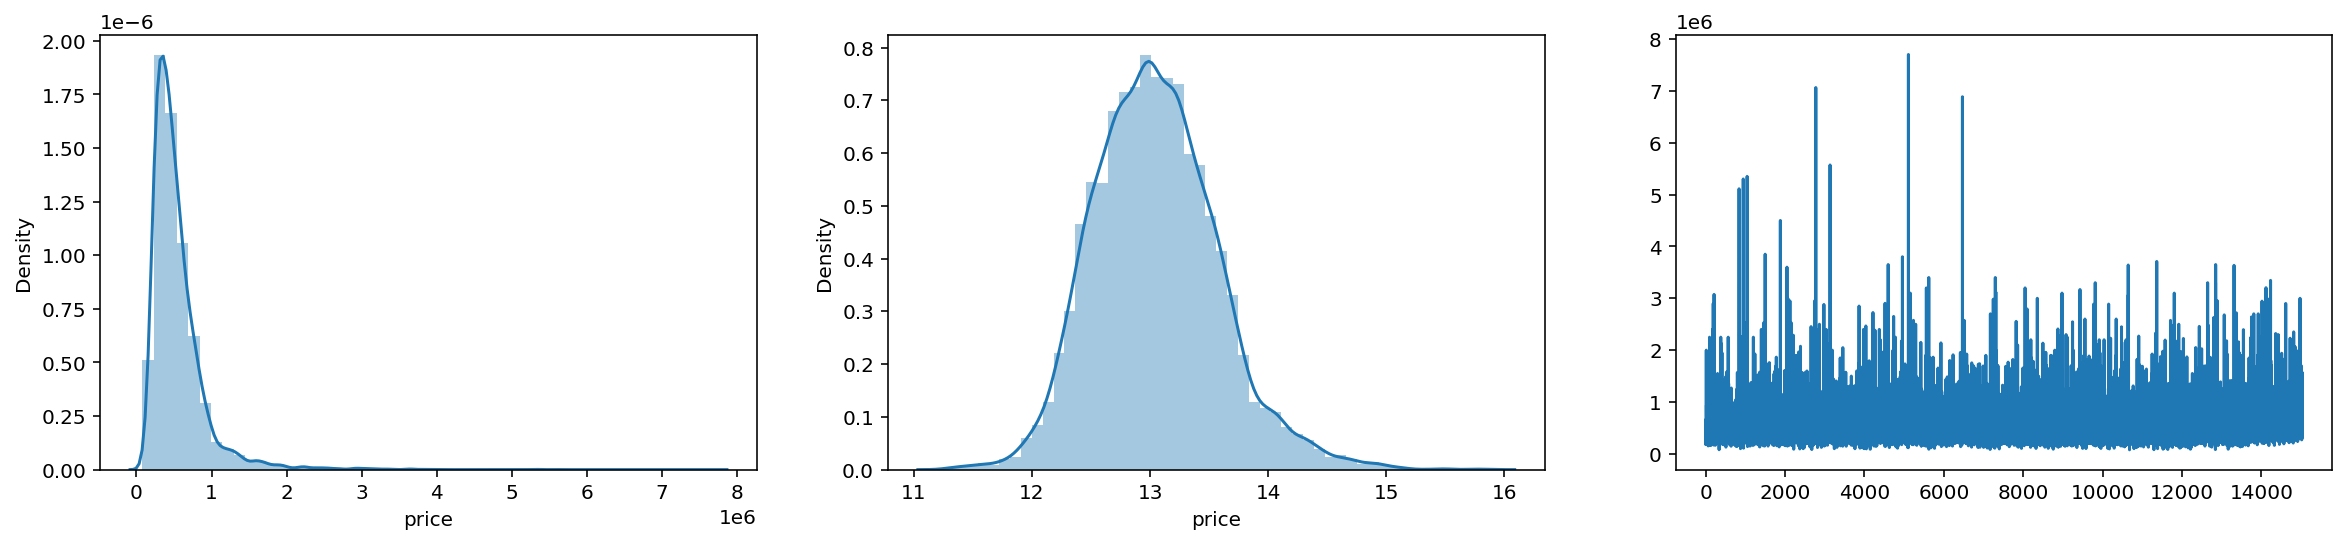

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(train_data['price'], ax=ax[0])
sns.distplot(np.log1p(train_data['price']), ax=ax[1])
train_data['price'].plot(ax=ax[2])
plt.show()

# 분포의 치우침을 해결할 수 있는 것으로 확인했기에 로그 변환을 실행해 줌
train_data['price'] = np.log1p(train_data['price'])

In [6]:
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


타겟 데이터인 price와 다른 데이터간의 상관관계를 확인

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

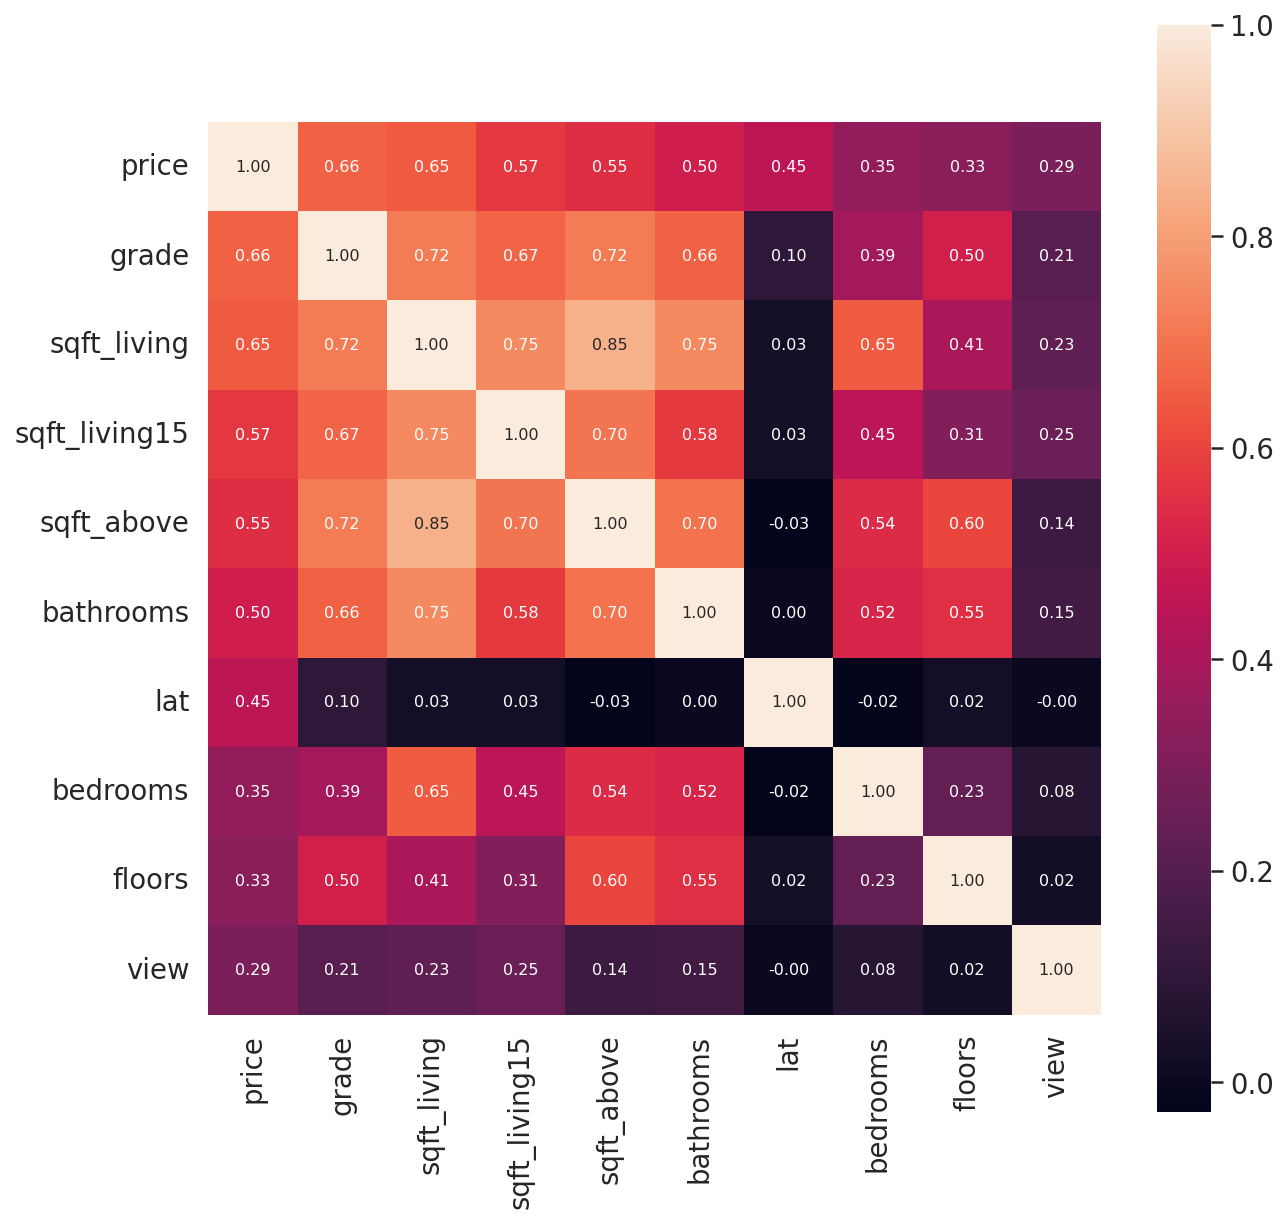

In [7]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# 반비례 관계도 고려하기 위해 절대값을 취해줌
# https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12?scriptVersionId=12697460의 코드를 사용
import scipy as sp

cor_abs = abs(train_data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train_data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

* 등급이나 크기와 같은 데이터는 예상 가능하지만 lat이라는 위도 데이터가 상위에 랭크된 것이 의외
* 위도의 경우, 지역에 따라 한쪽으로 집값이 높은 군집이 발생할 수 있기에 그럴듯하게 생각됨

## 4. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [8]:
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


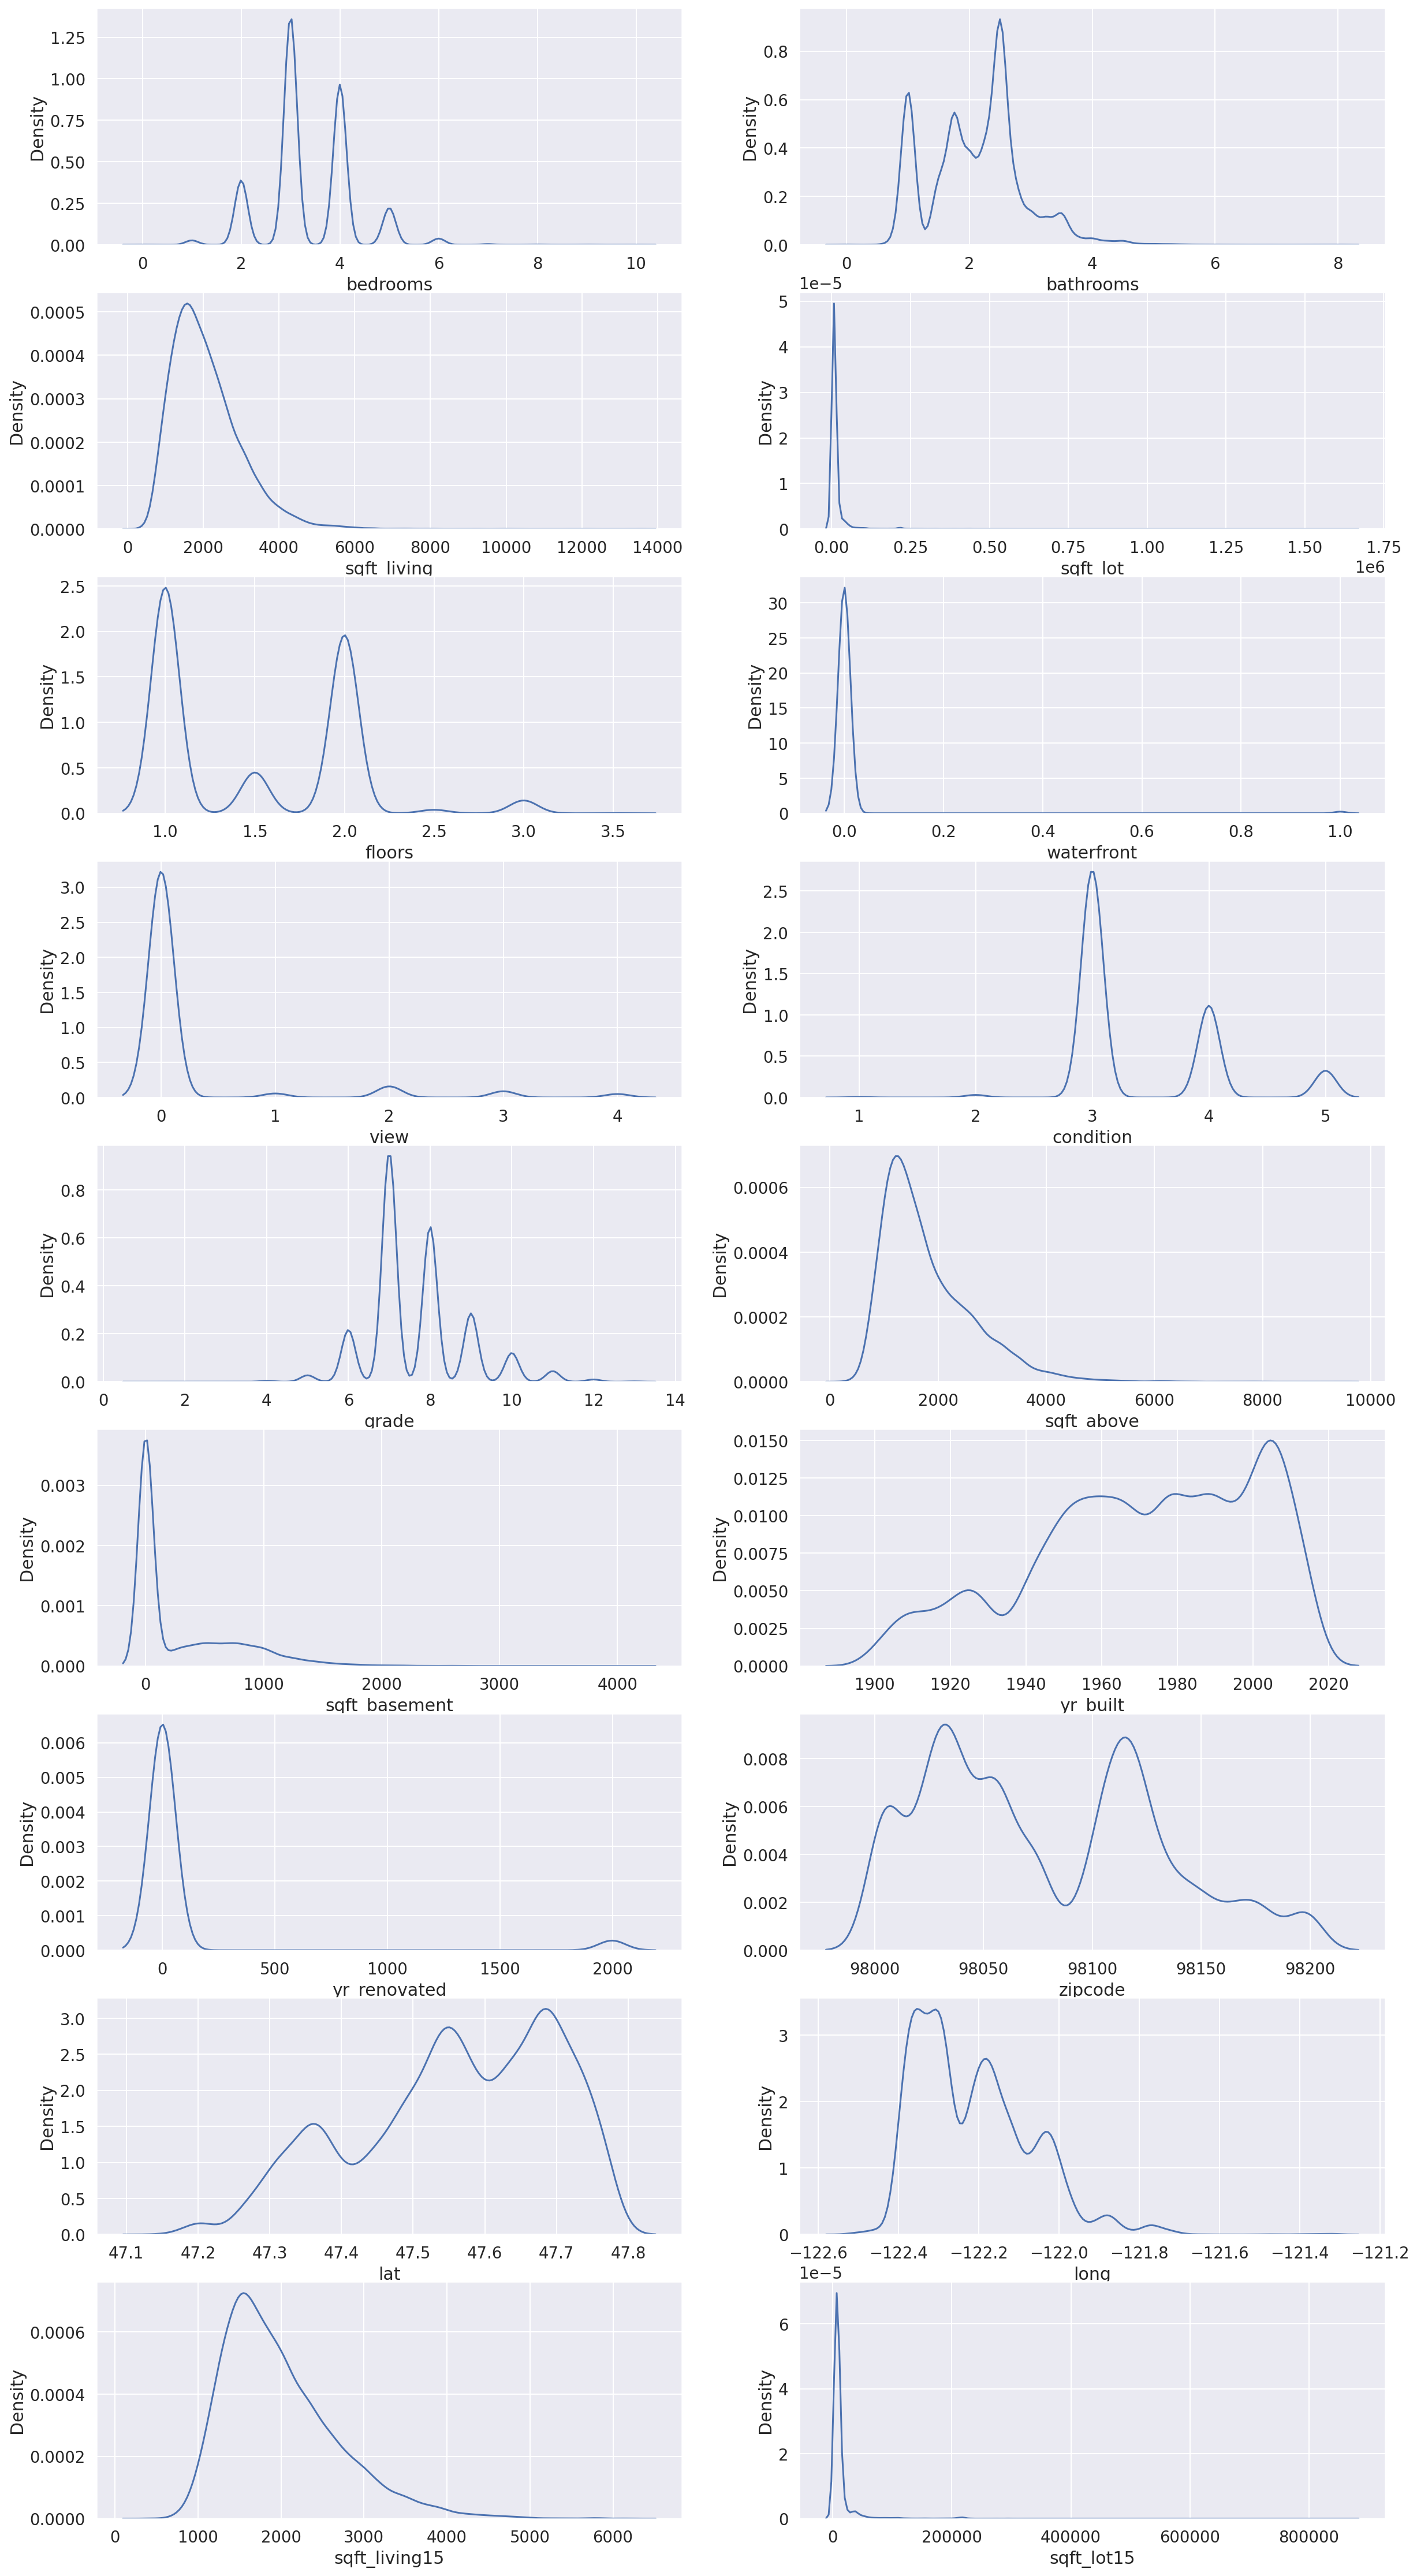

In [9]:
fig, ax = plt.subplots(9, 2, figsize=(20, 40))

# id 변수는 제외하고 분포를 확인합니다.
count = 3
columns = train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train_data[columns[count]], ax=ax[row][col])
        #ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [10]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train_data[c] = np.log1p(train_data[c].values)

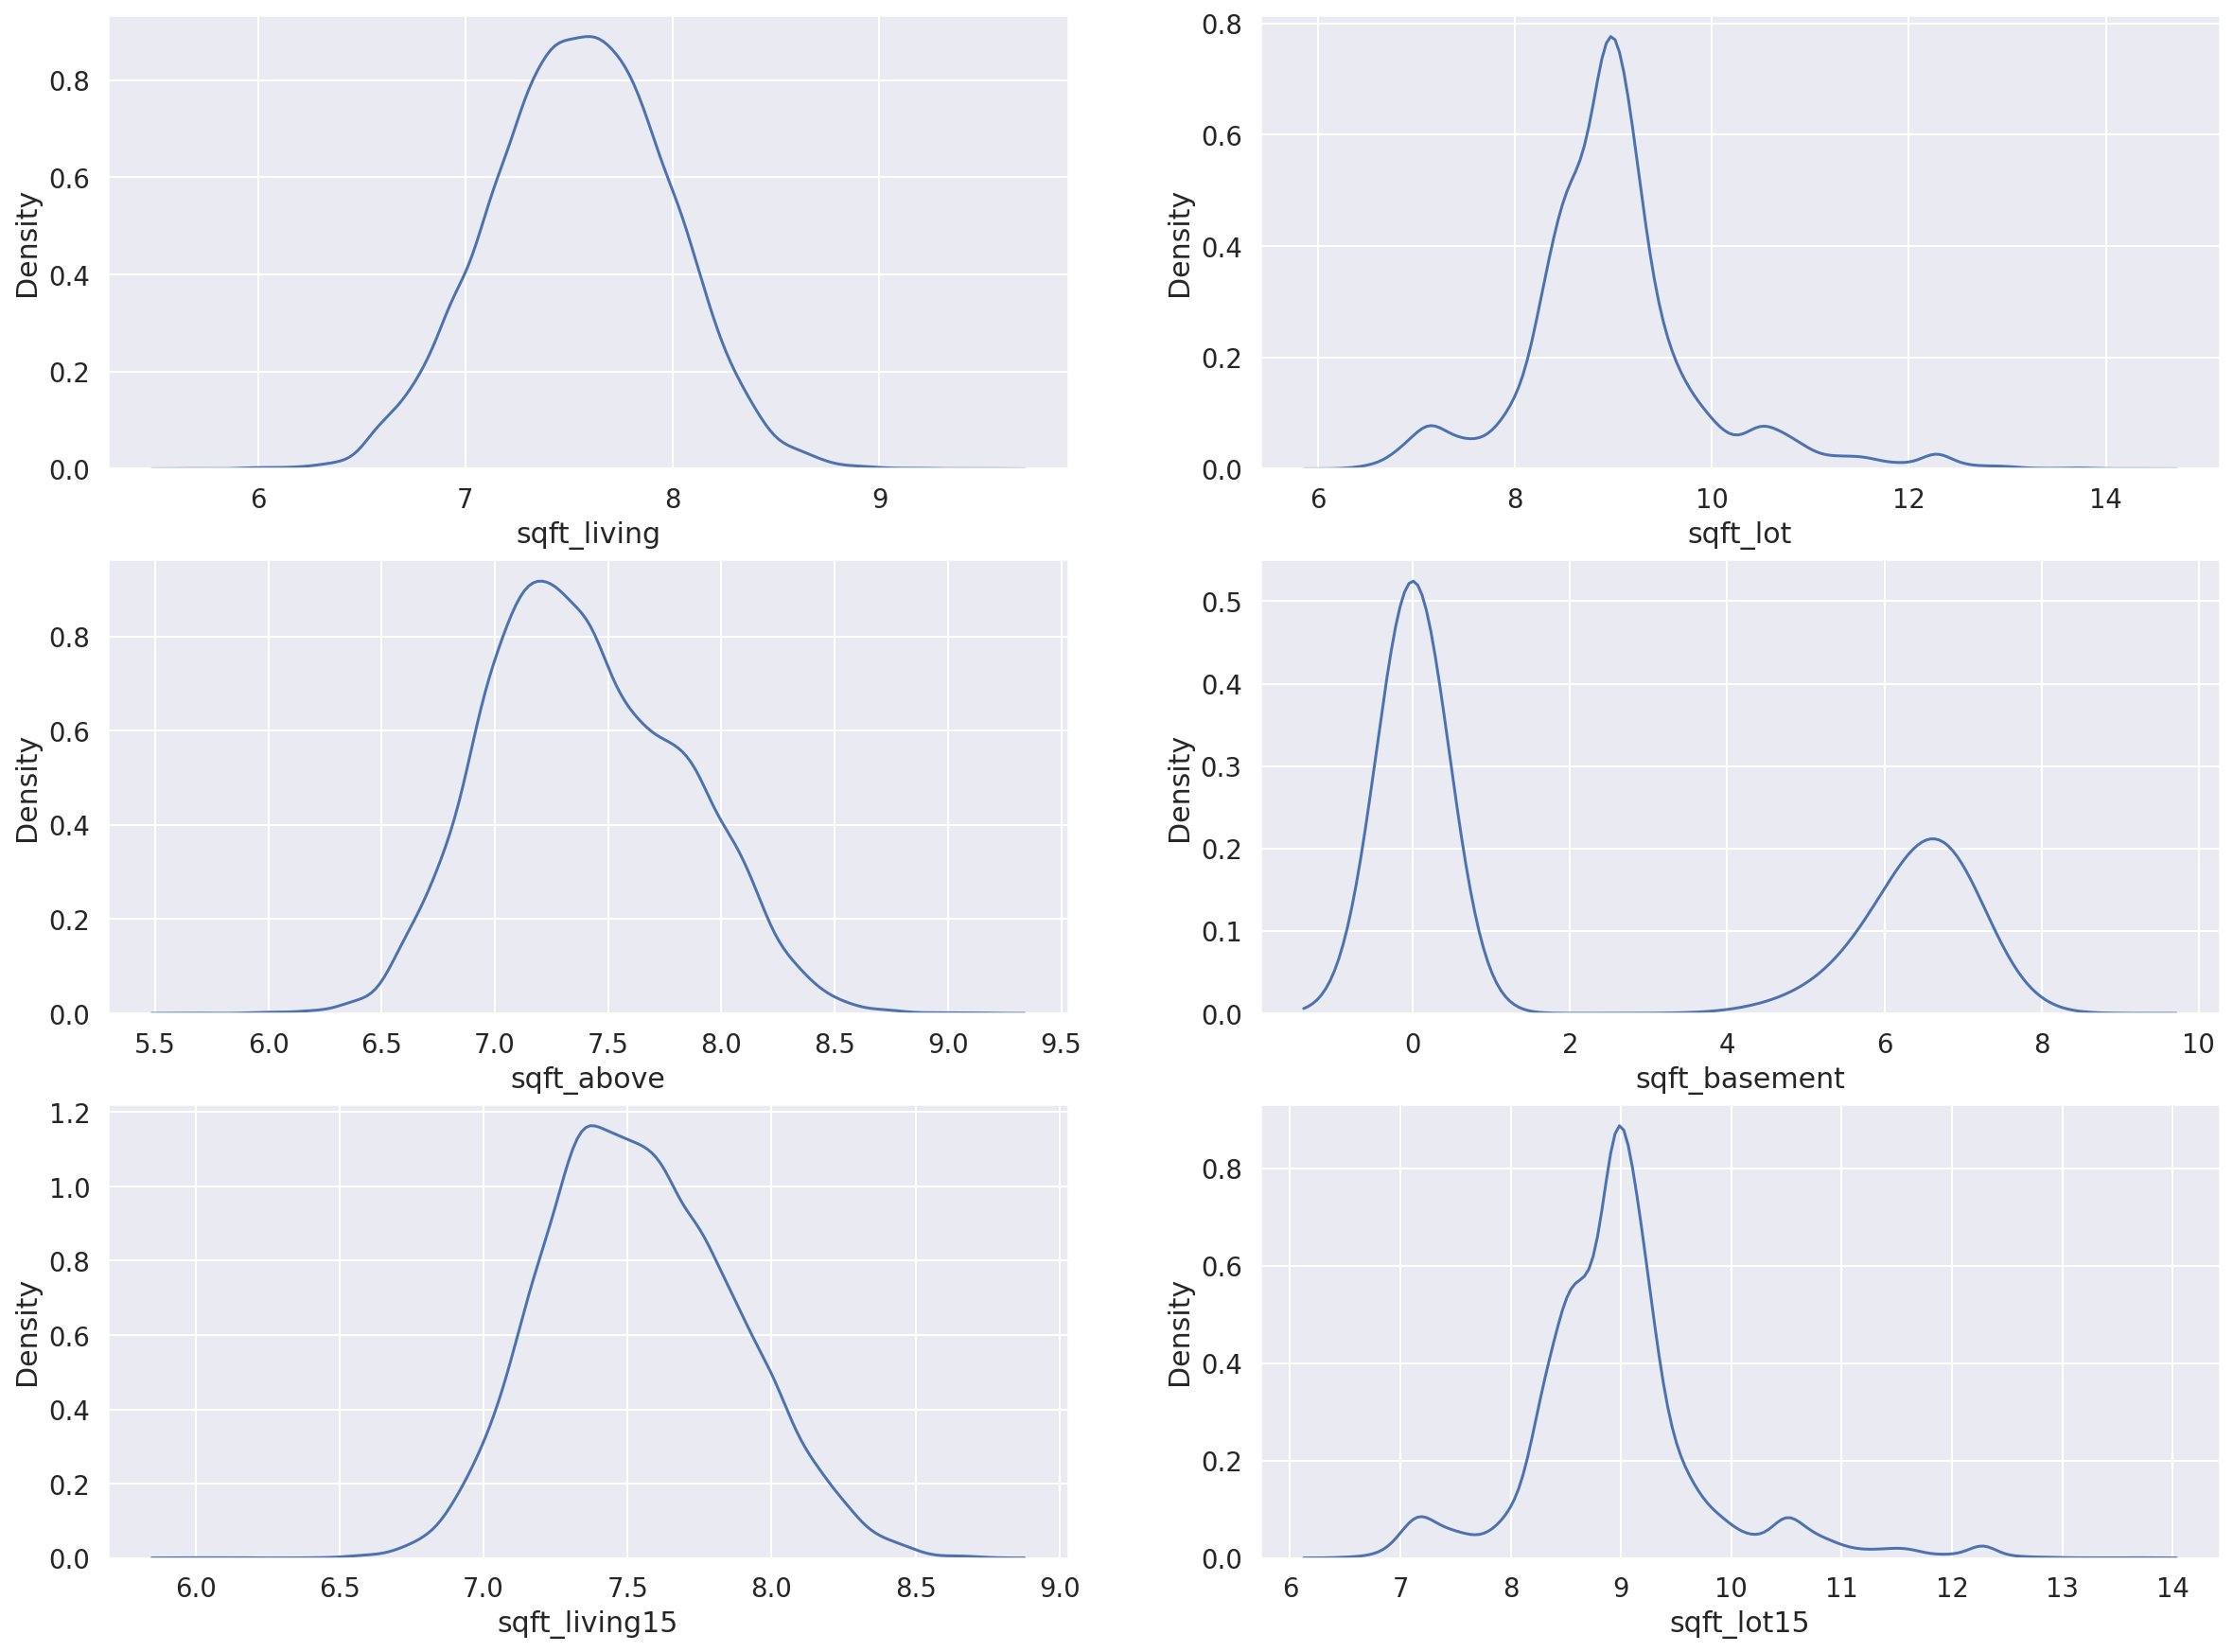

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(data=train_data[skew_columns[count]], ax=ax[row][col])
        #x[row][col].set_title(skew_columns[count], fontsize=1)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

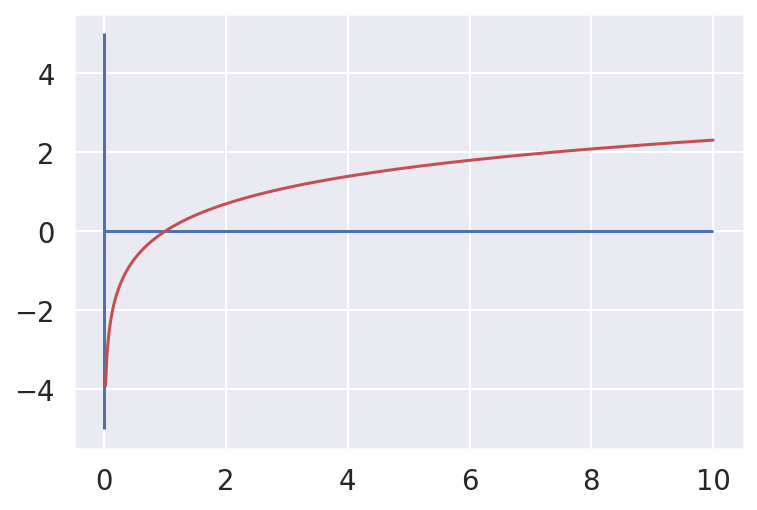

In [12]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

\# 로그 변환이 분포의 치우침을 줄어들게 하는 이유는???  


x가 0에서 1 사이에는 y값의 변화가 크고 x가 0에 가까울수록 y값이 무한대에 가까워진다.  
x가 1을 넘어가면 기울기가 완만해진다.  
그러므로 한쪽에 치우친 값들을 비교적 고르게 펴줄 수 있다.

#### 변수 정리
* date 칼럼을 단순화해줌 (6자리 정수)
* 재건축 일자가 없는 데이터는 nan 값을 넣어주고,  
넣어준 nan 값을 건축 일자로 채워준다.

In [13]:
for df in [train_data,test_data]:
    df['date'] = df['date'].apply(lambda x: x[0:6])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
    
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,7.201171,8.639588
1,1,201502,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,7.908755,8.995041
2,2,201502,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,7.496097,8.923191
3,3,201406,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,7.713785,8.827615
4,4,201501,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,7.409136,9.181118


#### 변수 생성

In [14]:
for df in [train_data,test_data]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    # 지상과 지하 면적의 합
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    # 15년도 거실의 비율
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [15]:
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,0,201410,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,...,47.5112,-122.257,7.201171,8.639588,4.00,0.818803,7.074117,1.0,0.833509,0
1,1,201502,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,...,47.7379,-122.233,7.908755,8.995041,3.00,0.721756,6.647688,1.0,0.879235,0
2,2,201502,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,...,47.6168,-122.045,7.496097,8.923191,5.00,0.825489,7.427144,1.0,0.840069,0
3,3,201406,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,...,47.3097,-122.327,7.713785,8.827615,5.25,0.843688,7.447751,1.0,0.873824,0
4,4,201501,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,...,47.4095,-122.315,7.409136,9.181118,4.50,0.758837,6.966967,1.0,0.806997,0


* 비슷한 지역에서의 집값이 유사하다는 특성을 이용하기 위한 변수 생성

In [16]:
train_data['per_price'] = train_data['price']/train_data['sqft_total_size']
zipcode_price = train_data.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train_data = pd.merge(train_data,zipcode_price,how='left',on='zipcode')
test_data = pd.merge(test_data,zipcode_price,how='left',on='zipcode')

for df in [train_data,test_data]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']
    
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,201410,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,...,8.639588,4.00,0.818803,7.074117,1.0,0.833509,0,31367.873300,217330.635001,1.242862e+09
1,1,201502,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,...,8.995041,3.00,0.721756,6.647688,1.0,0.879235,0,27077.081518,319567.647630,2.171972e+09
2,2,201502,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,...,8.923191,5.00,0.825489,7.427144,1.0,0.840069,0,68667.039556,580409.236003,6.788666e+09
3,3,201406,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,...,8.827615,5.25,0.843688,7.447751,1.0,0.873824,0,34574.194320,237333.442907,8.954380e+08
4,4,201501,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,...,9.181118,4.50,0.758837,6.966967,1.0,0.806997,0,41890.537761,230003.996070,1.524919e+09


## 5. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [17]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [18]:
# 학습이 가능하도록 데이터를 정제
train_columns = [c for c in train_data.columns if c not in ['id','price','per_price']]

X_train = train_data[train_columns]
y_train = np.log1p(train_data['price'])

In [19]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(X_train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X_train.values, y_train)), 
                                             kf=kfold))

In [20]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8854
Model XGBoost CV score : 0.8966
Model LightGBM CV score : 0.9025


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [21]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [22]:
sub_X = test_data[train_columns]
sub_id = test_data['id']

y_pred = AveragingBlending(models, X_train, y_train, sub_X)

print(len(y_pred))
y_pred

6468


array([14.12874626, 13.83273229, 14.68987161, ..., 14.39446684,
       14.17481825, 14.09000807])

In [23]:
# 제출을 위해 csv파일로 저장하기 위해 'sample_submission.csv'파일을 확인

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
# id와 price로 이루어진 데이터 프레임을 만들어야 함

result = pd.DataFrame({
    'id' : sub_id,
    'price' : np.expm1(y_pred)
})

result.head()

,id,price
0,15035,1.367843e+06
1,15036,1.017370e+06
2,15037,2.397342e+06
3,15038,9.145349e+05
4,15039,8.909228e+05


In [25]:
# result를 csv파일로 저장

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 6. 파라미터 수정

In [26]:
# 훈련 데이터셋과 검증 데이터셋을 나누기 위함
from sklearn.model_selection import train_test_split

# RMSE를 측정하기 위한 MSE 모듈 import
from sklearn.metrics import mean_squared_error

## 자주 사용할 함수 만들기(RMSE)

In [27]:
# RMSE를 측정하는 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 모델 불러오기

In [28]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [29]:
random_state = 2022 # 해당 값을 옵션으로 주어야 같은 모델과 같은 데이터셋에서 항상 같은 결과를 나타낼 수 있음

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [30]:
# 모델확인
gboost.__class__.__name__

'GradientBoostingRegressor'

## 각 모델의 스코어를 구하는 함수 만들기

In [31]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        # train, test set 분리 (random_state 고정!)
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # 예측 결과에 대해 RMSE 값을 구하고 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # 해당 값을 데이터 프레임에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

In [32]:
# 함수를 실행해보자
get_scores(models, X_train, y_train)

,RMSE
XGBRegressor,131119.070360
RandomForestRegressor,128537.060869
GradientBoostingRegressor,126792.642091
LGBMRegressor,122420.731173


## 하이퍼 파라미터 조절
### Grid Search(그리드 탐색)

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 'model'을 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                             cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델을 fitting
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 값을 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성 -> RMSLE 값 추가하고 해당 값이 낮은 순으로 정렬
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [35]:
param_grid = {
    'n_estimators': [600, 700, 800],
    'max_depth': [10],
    'learning_rate': [0.05, 0.01]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
1,0.05,10,700,-0.025774,0.160544
0,0.05,10,600,-0.025781,0.160565
2,0.05,10,800,-0.025817,0.160676
5,0.01,10,800,-0.026971,0.164227
4,0.01,10,700,-0.027320,0.165288
3,0.01,10,600,-0.027842,0.166860


learning_rate: 0.05, max_depth: 10. n_estimators: 700 일 때, 가장 낮은 RMSLE를 얻음

In [42]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

y_pred = AveragingBlending(models, X_train, y_train, sub_X)

print(len(y_pred))
y_pred

6468


array([14.15991563, 13.88020503, 14.70978083, ..., 14.46728325,
       14.23576023, 14.17358459])

[CV] END .learning_rate=0.05, max_depth=10, n_estimators=600; total time=   4.4s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=700; total time=   6.4s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=800; total time=   6.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=600; total time=   7.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=800; total time=   8.2s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=600; total time=   4.9s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=700; total time=   5.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=800; total time=   5.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=600; total time=   6.2s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=700; total time=   6.3s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=800; total time=   6.0s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=600; total time=   4.1s
[CV] END .learning_rate=0.05

In [45]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

result = pd.DataFrame({
    'id' : sub_id,
    'price' : np.expm1(y_pred)
})

print(result.head())

my_submission_path = join(data_dir, 'submission_1.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

      id         price
0  15035  1.411149e+06
1  15036  1.066832e+06
2  15037  2.445550e+06
3  15038  9.326262e+05
4  15039  9.281218e+05
/aiffel/aiffel/kaggle_kakr_housing/data/submission_1.csv


In [36]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, random_state=random_state)
model.fit(X_train, y_train)
prediction = model.predict(sub_X)
prediction

array([13.96613992, 14.04492387, 14.83638626, ..., 14.36343836,
       14.14624304, 14.15835294])

In [37]:
prediction = np.expm1(prediction)
prediction

array([1162564.68181413, 1257860.81967396, 2775623.32764363, ...,
       1729664.1013685 , 1391986.36632531, 1408945.67523872])

In [38]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [39]:
submission['price'] = prediction
submission.head()
print(np.expm1(prediction))

[inf inf inf ... inf inf inf]


In [40]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.160544')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160544.csv


In [41]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [43]:
save_submission(model, X_train, y_train, sub_X, 'lgbm', rmsle='0.0160852')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0160852.csv saved!


### ENSEMBLE 하기

직접 구현이 아직 어려워 참고 자료 활용  
https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

In [44]:
import lightgbm as lgb
import xgboost as xgb
import gc

import time
from datetime import datetime, timedelta,date

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

In [45]:
lgb_param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": random_state}

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 4950,
    'eta': 0.0123,
    'gamma':0,
    'max_depth':3,
    'reg_alpha':0.00006,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'silent': 1,
}

ridge_params = {'alpha':0.0001, 'normalize':True, 'max_iter':1e7, 'random_state':random_state}
lasso_params = {'alpha':0.0005, 'normalize':True, 'max_iter':1e7, 'random_state':random_state}
elastic_params = {'alpha':0.001, 'normalize':True, 'max_iter':1e3, 'random_state':random_state, 'l1_ratio':0.8}
svr_param = {'C':20, 'epsilon':0.008, 'gamma':0.0003}
gbr_param = {'n_estimators':3000, 'learning_rate':0.05, 'max_depth':4, 'max_features':'sqrt', 'min_samples_leaf':15, 'min_samples_split':10, 'loss':'huber', 'random_state':random_state }

In [46]:
from functools import wraps
def time_decorator(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("\nStartTime: ", datetime.now() + timedelta(hours=9))
        start_time = time.time()
        
        df = func(*args, **kwargs)
        
        print("EndTime: ", datetime.now() + timedelta(hours=9))  
        print("TotalTime: ", time.time() - start_time)
        return df
        
    return wrapper

class SklearnWrapper(object):
    def __init__(self, clf, params=None, **kwargs):
        #if isinstance(SVR) is False:
        #    params['random_state'] = kwargs.get('seed', 0)
        self.clf = clf(**params)
        self.is_classification_problem = True
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        if len(np.unique(y_train)) > 30:
            self.is_classification_problem = False
            
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        if self.is_classification_problem is True:
            return self.clf.predict_proba(x)[:,1]
        else:
            return self.clf.predict(x)   
    
class XgbWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
    
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        need_cross_validation = True
       
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
            
            print(train_round)
            self.clf = xgb.train(self.param, dtrain, train_round)
            del dtrain
        else:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent=True)
            dvalid = xgb.DMatrix(x_cross, label=y_cross, silent=True)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

            self.clf = xgb.train(self.param, dtrain, self.num_rounds, watchlist, feval=self.eval_function,
                                 early_stopping_rounds=self.early_stopping,
                                 verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)

    def predict(self, x):
        return self.clf.predict(xgb.DMatrix(x), ntree_limit=self.best_round)

    def get_params(self):
        return self.param    
    
class LgbmWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
        
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        """
        x_cross or y_cross is None
        -> model train limted num_rounds
        
        x_cross and y_cross is Not None
        -> model train using validation set
        """
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = lgb.Dataset(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
                
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=train_round)
            del dtrain   
        else:
            dtrain = lgb.Dataset(x_train, label=y_train, silent=True)
            dvalid = lgb.Dataset(x_cross, label=y_cross, silent=True)
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=self.num_rounds, valid_sets=[dtrain, dvalid],
                                  feval=self.eval_function, early_stopping_rounds=self.early_stopping,
                                  verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)
            del dtrain, dvalid
            
        gc.collect()
    
    def predict(self, x):
        return self.clf.predict(x, num_iteration=self.clf.best_iteration)
    
    def plot_importance(self):
        lgb.plot_importance(self.clf, max_num_features=50, height=0.7, figsize=(10,30))
        plt.show()
        
    def get_params(self):
        return self.param
    
    
@time_decorator
def get_oof(clf, x_train, y_train, x_test, eval_func, **kwargs):
    nfolds = kwargs.get('NFOLDS', 5)
    kfold_shuffle = kwargs.get('kfold_shuffle', True)
    kfold_random_state = kwargs.get('kfold_random_state', 0)
    stratified_kfold_ytrain = kwargs.get('stratifed_kfold_y_value', None)
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    kf_split = None
    if stratified_kfold_ytrain is None:
        kf = KFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train)
    else:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train, stratified_kfold_ytrain)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    cv_sum = 0
    
    # before running model, print model param
    # lightgbm model and xgboost model use get_params()
    try:
        if clf.clf is not None:
            print(clf.clf)
    except:
        print(clf)
        print(clf.get_params())

    for i, (train_index, cross_index) in enumerate(kf_split):
        x_tr, x_cr = None, None
        y_tr, y_cr = None, None
        if isinstance(x_train, pd.DataFrame):
            x_tr, x_cr = x_train.iloc[train_index], x_train.iloc[cross_index]
            y_tr, y_cr = y_train.iloc[train_index], y_train.iloc[cross_index]
        else:
            x_tr, x_cr = x_train[train_index], x_train[cross_index]
            y_tr, y_cr = y_train[train_index], y_train[cross_index]

        clf.train(x_tr, y_tr, x_cr, y_cr)
        
        oof_train[cross_index] = clf.predict(x_cr)

        cv_score = eval_func(y_cr, oof_train[cross_index])
        
        print('Fold %d / ' % (i+1), 'CV-Score: %.6f' % cv_score)
        cv_sum = cv_sum + cv_score
        
        del x_tr, x_cr, y_tr, y_cr
        
    gc.collect()
    
    score = cv_sum / nfolds
    print("Average CV-Score: ", score)

    # Using All Dataset, retrain
    clf.train(x_train, y_train)
    oof_test = clf.predict(x_test)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), score

In [47]:
xgb_model = XgbWrapper(params=xgb_params, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

lgb_model = LgbmWrapper(params=lgb_param, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

ridge_model = SklearnWrapper(Ridge, params=ridge_params)
lasso_model = SklearnWrapper(Lasso, params=lasso_params)
elastic_model = SklearnWrapper(ElasticNet, params=lasso_params)
svr_model = SklearnWrapper(SVR, params=svr_param)
gbr_model = SklearnWrapper(GradientBoostingRegressor, params=gbr_param)

In [48]:
x_train = train_data.copy()
y_train = np.log1p(train_data['price'])
del x_train['price']

x_test = test_data.copy()
del x_test['id']

x_train_rb = x_train.copy()
x_test_rb = x_test.copy()
rb = RobustScaler()
x_train_rb[train_columns] = rb.fit_transform(x_train_rb[train_columns].fillna(-1))
x_test_rb[train_columns] = rb.transform(x_test_rb[train_columns].fillna(-1))

In [ ]:
ridge_train, ridge_test, ridge_cv_score = get_oof(ridge_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

lasso_train, lasso_test, lasso_cv_score = get_oof(lasso_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

elastic_train, elastic_test, lasso_cv_score = get_oof(elastic_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

svr_train, svr_test, lasso_cv_score = get_oof(svr_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

gbr_train, gbr_test, lasso_cv_score = get_oof(gbr_model, x_train[train_columns].fillna(-1), y_train, x_test[train_columns].fillna(-1), 
                            rmse, NFOLDS=5, kfold_random_state=4950)

xgb_train, xgb_test, xgb_cv_score = get_oof(xgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

lgb_train, lgb_test, lgb_cv_score = get_oof(lgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)


StartTime:  2022-01-25 23:06:25.520716
Ridge(alpha=0.0001, max_iter=10000000.0, normalize=True, random_state=2022)

StartTime:  2022-01-25 23:06:25.525108
EndTime:  2022-01-25 23:06:25.533891
TotalTime:  0.008860111236572266
Fold 1 /  CV-Score: 176685.644485

StartTime:  2022-01-25 23:06:25.540266
EndTime:  2022-01-25 23:06:25.550060
TotalTime:  0.009753942489624023
Fold 2 /  CV-Score: 150910.715302

StartTime:  2022-01-25 23:06:25.556158
EndTime:  2022-01-25 23:06:25.566257
TotalTime:  0.010190486907958984
Fold 3 /  CV-Score: 146969.016978

StartTime:  2022-01-25 23:06:25.572339
EndTime:  2022-01-25 23:06:25.581314
TotalTime:  0.00904989242553711
Fold 4 /  CV-Score: 143874.128206

StartTime:  2022-01-25 23:06:25.587039
EndTime:  2022-01-25 23:06:25.596156
TotalTime:  0.009185314178466797
Fold 5 /  CV-Score: 147661.022947
Average CV-Score:  153220.1055836083

StartTime:  2022-01-25 23:06:25.741484
EndTime:  2022-01-25 23:06:25.749824
TotalTime:  0.008404016494750977
EndTime:  2022-01-

어떤 이유에서인지 XGBoost 학습 도중 커널이 죽어버림.  
ENSEMBLE을 이용한 결과를 내지 못함

#### 평가 루브릭

1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?  
 -> 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.  


2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?  
 -> 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  


3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?  
 -> 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.


참조  
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12?scriptVersionId=12697460
https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

# 회고

1. 
* 데이터를 분석하고 전처리하여 모델을 학습하고 예측하는 과정을 순차적으로 수행하고 캐글 submission까지 완료. 
그러나 캐글 업로드 후 얻은 스코어가 상당히 높은 값이라 중간 과정에서 잘못이 있을 것으로 예상.  

* 처음에는 price 값을 MSE비교를 위해 로그 변환이나 지수 변환하는 과정에서 실수가 있었을 것으로 예상했으나  
아무리 봐도 이 과정에서는 문제가 없다.  

* 그 다음 예상으로는 데이터 전처리 과정에서 데이터의 처리가 잘못 되었을 가능성이 있다는 것이다.  
그러나 이 부분은 확인을 못함.

2.
* 전처리, 학습, 최적화 코드 각각이 어떤 역할을 하는지에 대한 설명을 포함하고 있으며,  
데이터 전처리 과정에서 시각화 자료를 통해 자료를 분석함.

* 다만, 다른 사람의 코드를 가져온 부분에서 아직 완전한 이해가 바탕되지 않아 설명이 부족.

3.
* 캐글 private score가 최적화를 진행하지 않고 가장 처음 제출했던 것에서 116130.98270을 기록하여 기준점인 110000 아래로 내리지 못함.

* 하이퍼파라미터를 조절하기위해 그리드 탐색을 사용했고, 전처리 과정에서 피처 엔지니어링도 수행했지만 결과는 오히려 상당히 안좋아짐.

* 1번에서 언급한 것과 같이 문제점 파악이 제대로 되지 않았지만, 데이터 전처리 과정에서 모델과 어울리지 않는 방향으로 수행된 것 같음.

4.
* 전반적으로 중간 과정에서 시간을 많이 할애하여 데이터에 대한 완전한 분석이 이뤄져야 했는데 그렇지 못했다.
* 코드에 관해서도 데이터 변환 과정이 많다보니 따라가기 조금 어려운 부분이 있었다.
* 항상 과제를 미루면서 했었는데 다음부터는 확실히 시간을 할애하여 미리미리 해야겠다....